# Linear Regression Dataset Challenge


### The Data:

The *Great* State of Iowa has excellent open data policies. In this example, we'll look at liquor store sales in 2019.

You have two data sets:
1. Daily Sales records per item per store for the 1st Quarter of 2019
2. Year-End Sales totals for ~700 stores

### The Goal:

Using Q1 data, predict end of year sales for each store 


### Your code should:
* Aggregate and combine the *raw datasets* to create a modeling dataset that correctly represents our goal
* Engineer appropriate features
* Use Cross Validation to select:
    * Appropriate Model
    * Best Feature Set
    * Best Hyperparameters





In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn import metrics

%matplotlib inline

In [2]:
data = pd.read_csv('./data/IL_Q1.csv')
targets = pd.read_csv('./data/IL_EOY_byStore.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449521 entries, 0 to 449520
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bottle_volume_ml     449521 non-null  int64  
 1   category             449040 non-null  float64
 2   itemno               449521 non-null  int64  
 3   pack                 449521 non-null  int64  
 4   sale_bottles         449521 non-null  int64  
 5   sale_dollars         449521 non-null  float64
 6   sale_gallons         449521 non-null  float64
 7   sale_liters          449521 non-null  float64
 8   state_bottle_cost    449521 non-null  float64
 9   state_bottle_retail  449521 non-null  float64
 10  store                449521 non-null  int64  
 11  vendor_no            449521 non-null  int64  
 12  zipcode              449429 non-null  float64
 13  quarter              449521 non-null  int64  
dtypes: float64(7), int64(7)
memory usage: 48.0 MB


In [4]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   store           699 non-null    int64  
 1   year_end_sales  699 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.0 KB


In [5]:
data.head()

,bottle_volume_ml,category,itemno,pack,sale_bottles,sale_dollars,sale_gallons,sale_liters,state_bottle_cost,state_bottle_retail,store,vendor_no,zipcode,quarter
0,375,1012100.0,10790,24,1,12.00,0.09,0.37,8.00,12.00,5111,260,52240.0,1
1,1000,1012200.0,10009,12,12,121.32,3.17,12.00,6.74,10.11,2285,421,52240.0,1
2,750,1012100.0,10807,12,36,842.04,7.13,27.00,15.59,23.39,4015,260,50010.0,1
3,750,1031100.0,36873,12,6,27.00,1.18,4.50,3.00,4.50,2550,229,50213.0,1
4,1000,1012100.0,10627,12,2,29.14,0.52,2.00,9.71,14.57,4291,65,50801.0,1


In [6]:
targets.head()

,store,year_end_sales
0,2106,1223186.94
1,2113,78947.79
2,2130,1173271.75
3,2178,330402.66
4,2190,2124405.10


In [7]:
df = pd.merge(left=data, right=targets, left_on="store", right_on="store")

In [8]:
df.head()

,bottle_volume_ml,category,itemno,pack,sale_bottles,sale_dollars,sale_gallons,sale_liters,state_bottle_cost,state_bottle_retail,store,vendor_no,zipcode,quarter,year_end_sales
0,375,1012100.0,10790,24,1,12.00,0.09,0.37,8.00,12.00,5111,260,52240.0,1,45377.07
1,375,1012100.0,10805,24,3,36.00,0.29,1.12,8.00,12.00,5111,260,52240.0,1,45377.07
2,750,1701100.0,10802,12,1,23.39,0.19,0.75,15.59,23.39,5111,260,52240.0,1,45377.07
3,375,1012100.0,10805,24,2,24.00,0.19,0.75,8.00,12.00,5111,260,52240.0,1,45377.07
4,375,1012100.0,10790,24,1,12.00,0.09,0.37,8.00,12.00,5111,260,52240.0,1,45377.07


In [11]:
df.describe()

,bottle_volume_ml,category,itemno,pack,sale_bottles,sale_dollars,sale_gallons,sale_liters,state_bottle_cost,state_bottle_retail,store,vendor_no,zipcode,quarter,year_end_sales
count,449521.000000,4.490400e+05,449521.000000,449521.000000,449521.000000,449521.000000,449521.000000,449521.000000,449521.000000,449521.000000,449521.000000,449521.000000,449429.000000,449521.0,4.495210e+05
mean,911.156122,1.048496e+06,50010.024911,12.396068,10.615535,138.977995,2.401828,9.112100,10.377825,15.568667,3740.200093,262.580049,51266.135875,1.0,9.572368e+05
std,506.116913,7.759822e+04,74934.897609,8.087473,27.181490,410.207399,8.186556,30.988399,8.685747,13.028701,1105.675483,137.098390,994.488623,0.0,1.725206e+06
min,50.000000,1.011100e+06,159.000000,1.000000,1.000000,1.340000,0.010000,0.050000,0.890000,1.340000,2106.000000,35.000000,50003.000000,1.0,3.255796e+04
25%,750.000000,1.012200e+06,27025.000000,6.000000,2.000000,30.600000,0.390000,1.500000,5.540000,8.310000,2607.000000,115.000000,50315.000000,1.0,1.974216e+05
50%,750.000000,1.031200e+06,39706.000000,12.000000,6.000000,71.400000,1.260000,4.800000,8.250000,12.380000,3773.000000,260.000000,51103.000000,1.0,4.353856e+05
75%,1000.000000,1.062500e+06,64866.000000,12.000000,12.000000,141.720000,2.770000,10.500000,12.970000,19.460000,4757.000000,389.000000,52310.000000,1.0,1.162205e+06
max,6000.000000,1.901200e+06,999292.000000,48.000000,2304.000000,30856.320000,554.760000,2100.000000,1166.000000,1749.000000,5713.000000,978.000000,52807.000000,1.0,1.187716e+07


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 449521 entries, 0 to 449520
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bottle_volume_ml     449521 non-null  int64  
 1   category             449040 non-null  float64
 2   itemno               449521 non-null  int64  
 3   pack                 449521 non-null  int64  
 4   sale_bottles         449521 non-null  int64  
 5   sale_dollars         449521 non-null  float64
 6   sale_gallons         449521 non-null  float64
 7   sale_liters          449521 non-null  float64
 8   state_bottle_cost    449521 non-null  float64
 9   state_bottle_retail  449521 non-null  float64
 10  store                449521 non-null  int64  
 11  vendor_no            449521 non-null  int64  
 12  zipcode              449429 non-null  float64
 13  quarter              449521 non-null  int64  
 14  year_end_sales       449521 non-null  float64
dtypes: float64(8), in

Only a few missing values, for zip code and category. Going to just fill these with 0, as I don't think the item category number will be very informative anyway without outside information. 

In [13]:
df.fillna(0)

,bottle_volume_ml,category,itemno,pack,sale_bottles,sale_dollars,sale_gallons,sale_liters,state_bottle_cost,state_bottle_retail,store,vendor_no,zipcode,quarter,year_end_sales
0,375,1012100.0,10790,24,1,12.00,0.09,0.37,8.00,12.00,5111,260,52240.0,1,45377.07
1,375,1012100.0,10805,24,3,36.00,0.29,1.12,8.00,12.00,5111,260,52240.0,1,45377.07
2,750,1701100.0,10802,12,1,23.39,0.19,0.75,15.59,23.39,5111,260,52240.0,1,45377.07
3,375,1012100.0,10805,24,2,24.00,0.19,0.75,8.00,12.00,5111,260,52240.0,1,45377.07
4,375,1012100.0,10790,24,1,12.00,0.09,0.37,8.00,12.00,5111,260,52240.0,1,45377.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449516,750,1012400.0,15940,12,12,270.00,2.37,9.00,15.00,22.50,5307,240,50131.0,1,274175.22
449517,750,1051100.0,55086,12,6,49.32,1.18,4.50,5.48,8.22,5307,434,50131.0,1,274175.22
449518,750,1031200.0,41989,12,3,29.25,0.59,2.25,6.50,9.75,5307,380,50131.0,1,274175.22
449519,750,1081600.0,64865,12,240,3232.80,47.55,180.00,8.98,13.47,5307,421,50131.0,1,274175.22


In [26]:
new_df = df.groupby("store").agg({"zipcode": "max", "state_bottle_cost": "sum", "sale_bottles": "sum", "sale_dollars": "sum", "state_bottle_retail": "sum", "bottle_volume_ml": "mean", "year_end_sales": "max"})


In [27]:
new_df.reset_index(inplace=True)

In [28]:
new_df

,store,zipcode,state_bottle_cost,sale_bottles,sale_dollars,state_bottle_retail,bottle_volume_ml,year_end_sales
0,2106,50613.0,11654.28,20170,293786.10,17483.74,894.043062,1223186.94
1,2113,50543.0,4756.07,1490,19676.95,7135.25,958.908046,78947.79
2,2130,50703.0,9758.91,17756,281669.28,14640.45,975.288351,1173271.75
3,2178,52172.0,5897.62,4841,66200.41,8847.74,950.440141,330402.66
4,2190,50314.0,49620.35,29657,428759.04,74437.73,831.114245,2124405.10
...,...,...,...,...,...,...,...,...
687,5705,52241.0,3570.41,5177,55730.64,5356.27,714.450867,219503.65
688,5706,52627.0,2534.06,5438,36429.83,3801.80,685.897436,178601.54
689,5708,52361.0,1896.81,1539,22550.57,2845.50,1267.170330,147137.04
690,5709,50014.0,4379.41,1808,24204.59,6569.84,913.554987,122917.96


Throwing a linear model at it to see how it does so far: 

In [34]:
lr = LinearRegression()

X = new_df.iloc[:, :-1]
y = new_df.iloc[:, -1:]

lr.fit(X, y)
lr.score(X, y)

0.9833614492874465

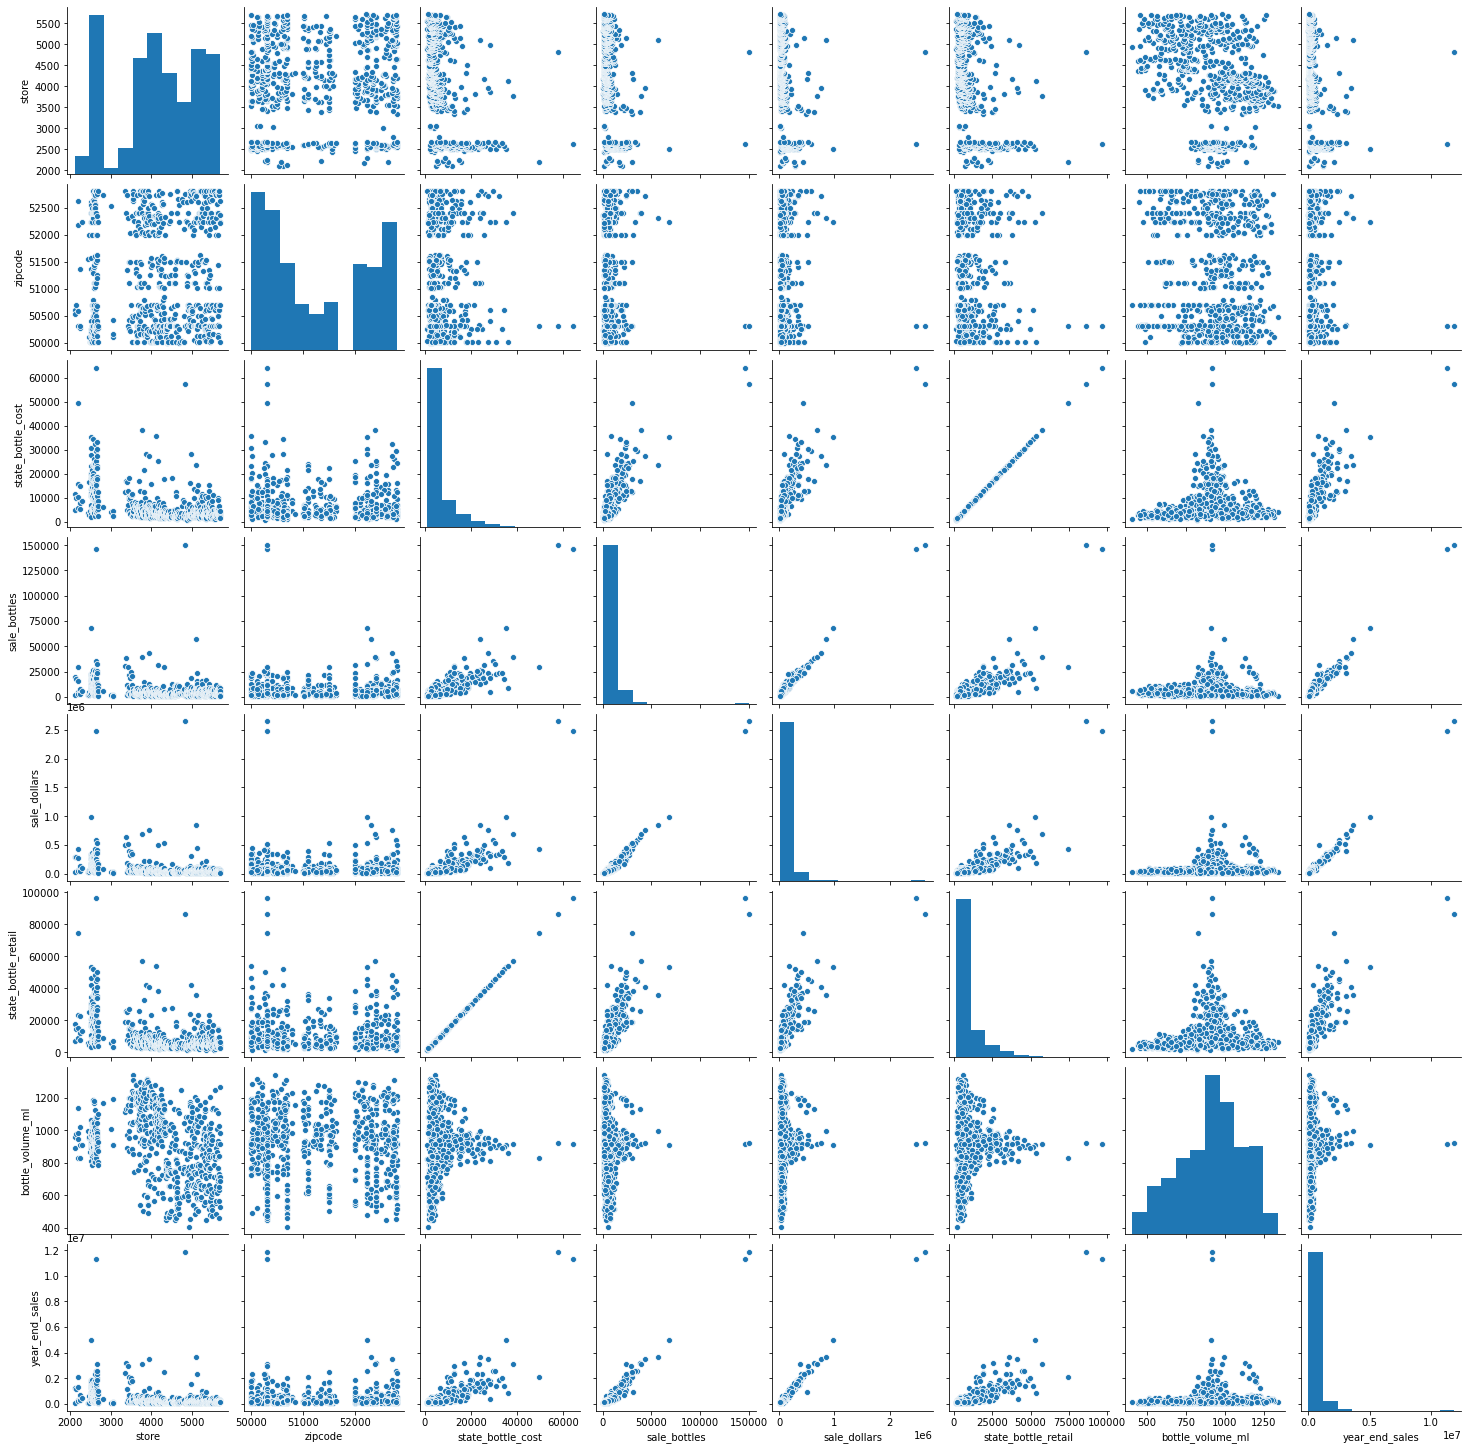

In [32]:
sns.pairplot(new_df)

The state_bottle_cost, sale_bottles, sale_dollars, and state_bottle_retail in the first quarter all look to be linearly related to the year end sales. 

The year end sales also looks left skewed -- outlier to be removed? Or does it need to be transformed? 

In [37]:
new_df.describe()

,store,zipcode,state_bottle_cost,sale_bottles,sale_dollars,state_bottle_retail,bottle_volume_ml,year_end_sales
count,692.000,692.000,692.000,692.000,692.000,692.000,692.000,692.000
mean,4164.548,51266.600,6741.402,6895.818,90279.663,10113.357,915.315,432054.817
std,1010.627,990.143,6962.182,10260.343,170668.550,10444.387,205.882,800829.753
min,2106.000,50003.000,991.670,692.000,8404.760,1487.720,407.449,32557.960
25%,3625.750,50316.750,2866.190,2502.750,25680.063,4299.845,768.708,120007.975
50%,4218.500,51052.000,4224.475,4281.000,49188.480,6337.485,929.800,226600.065
75%,5068.500,52310.000,7216.892,7481.750,88817.880,10826.703,1063.789,426538.965
max,5713.000,52807.000,64154.510,150488.000,2649563.220,96242.730,1342.391,11877163.590


In [40]:
new_df["year_end_sales"].sort_values(ascending=False).head(20)

469   11877163.590
108   11275151.830
23     5001156.460
526    3639515.180
266    3504665.150
144    3147579.420
216    3082936.130
128    3073797.650
148    2963108.240
102    2543035.650
131    2538116.340
376    2476180.310
143    2387732.100
129    2332218.270
96     2321730.700
544    2307609.820
4      2124405.100
150    2059164.080
156    2007276.760
117    1976765.730
Name: year_end_sales, dtype: float64

I guess it's not crazy to think that a couple of stores could have made 11 million...... ? 

In [41]:
small_df = new_df.loc[new_df["year_end_sales"] <= 5000000]

In [42]:
small_df.describe()

,store,zipcode,state_bottle_cost,sale_bottles,sale_dollars,state_bottle_retail,bottle_volume_ml,year_end_sales
count,689.000,689.000,689.000,689.000,689.000,689.000,689.000,689.000
mean,4168.205,51267.943,6542.883,6396.247,81807.323,9815.543,915.308,393074.691
std,1008.854,990.282,6238.462,6466.955,101036.395,9358.672,206.330,500974.330
min,2106.000,50003.000,991.670,692.000,8404.760,1487.720,407.449,32557.960
25%,3628.000,50317.000,2866.070,2502.000,25641.670,4299.680,768.416,119482.930
50%,4228.000,51054.000,4205.430,4266.000,49118.350,6309.070,931.604,224421.640
75%,5070.000,52310.000,7146.820,7410.000,88388.960,10721.970,1064.471,418670.810
max,5713.000,52807.000,49620.350,56972.000,847143.850,74437.730,1342.391,3639515.180


In [43]:
len(small_df["store"].unique())

689

Only 3 out of almost 700 stores made that much, so I'm excluding them. 

In [44]:
X = small_df.iloc[:, :-1]
y = small_df.iloc[:, -1:]

lr.fit(X, y)
lr.score(X, y)

0.9590441593303138

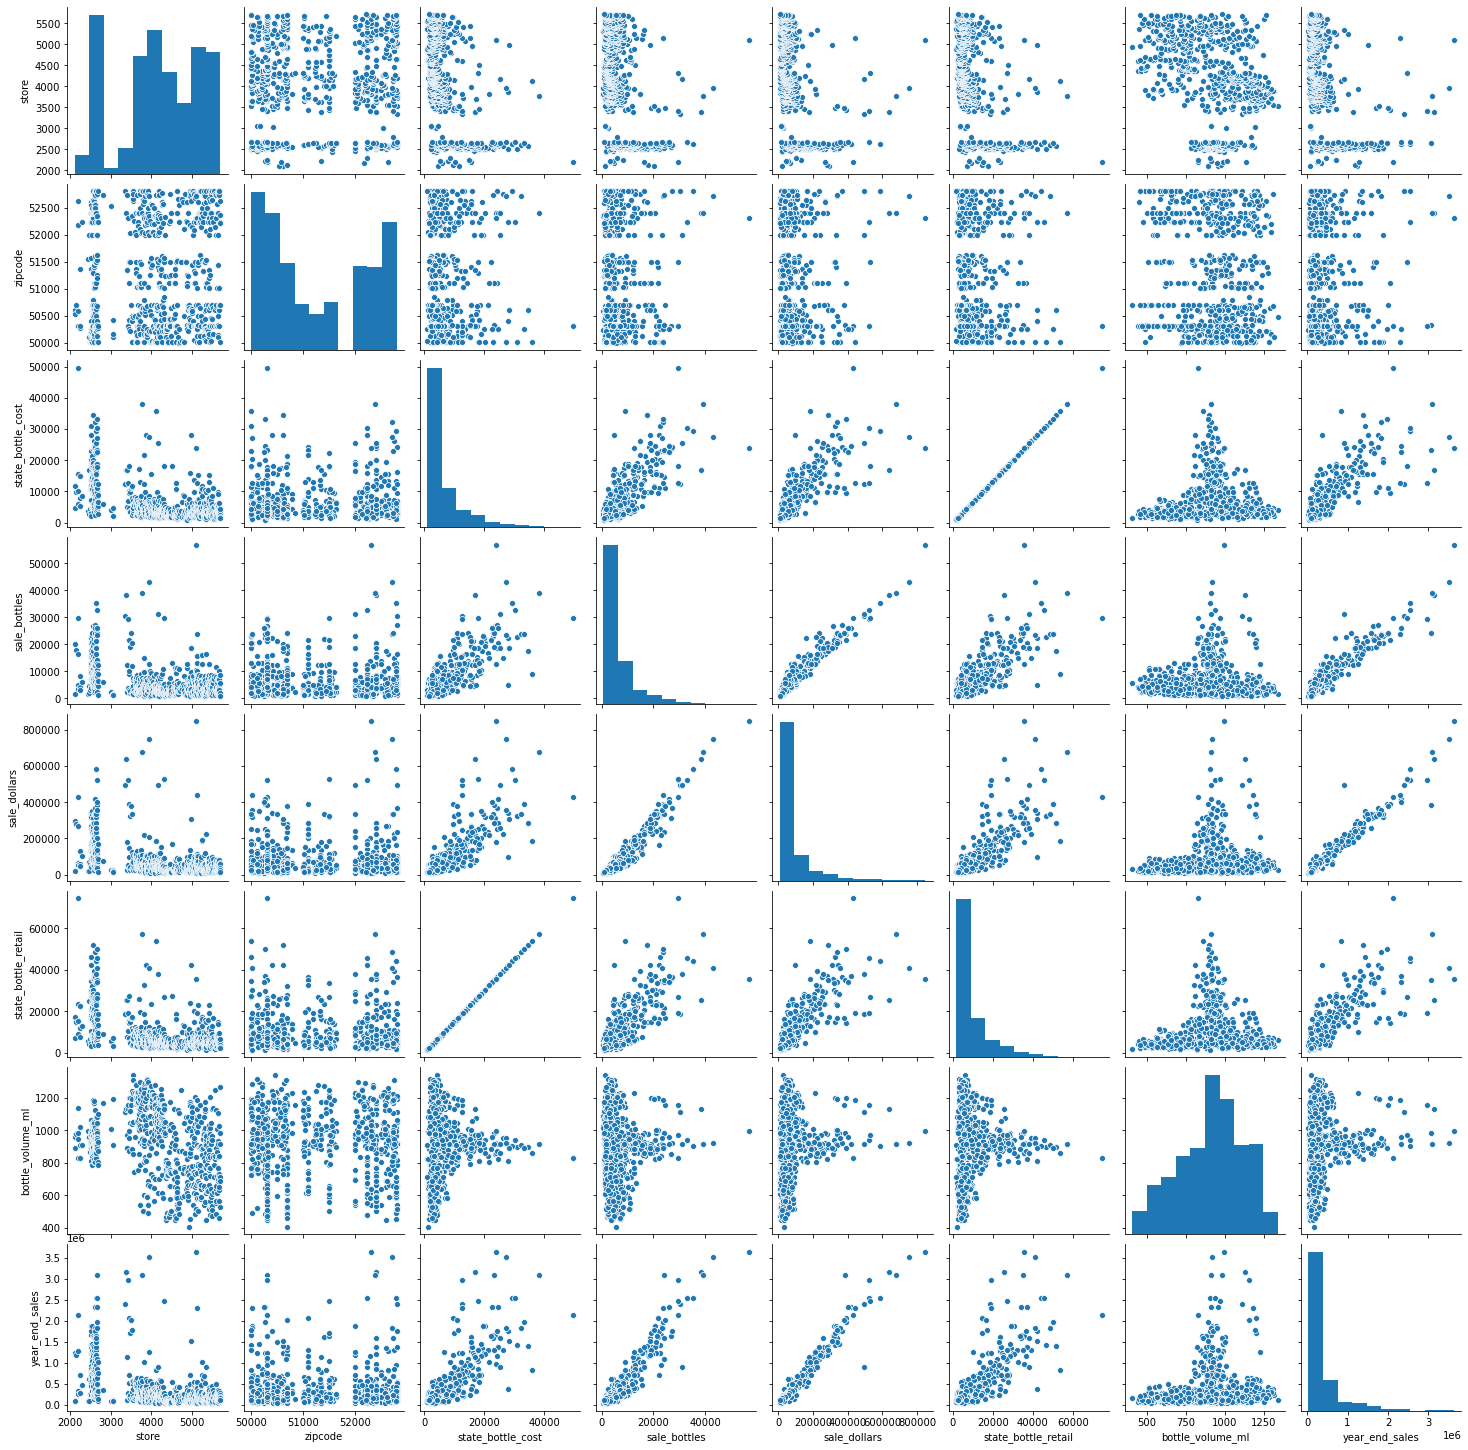

In [45]:
sns.pairplot(small_df)

Year end sales still left skewed, and R^2 is actually worse, so going to leave the highest values in! 

In [47]:
new_df.describe()

,store,zipcode,state_bottle_cost,sale_bottles,sale_dollars,state_bottle_retail,bottle_volume_ml,year_end_sales
count,692.000,692.000,692.000,692.000,692.000,692.000,692.000,692.000
mean,4164.548,51266.600,6741.402,6895.818,90279.663,10113.357,915.315,432054.817
std,1010.627,990.143,6962.182,10260.343,170668.550,10444.387,205.882,800829.753
min,2106.000,50003.000,991.670,692.000,8404.760,1487.720,407.449,32557.960
25%,3625.750,50316.750,2866.190,2502.750,25680.063,4299.845,768.708,120007.975
50%,4218.500,51052.000,4224.475,4281.000,49188.480,6337.485,929.800,226600.065
75%,5068.500,52310.000,7216.892,7481.750,88817.880,10826.703,1063.789,426538.965
max,5713.000,52807.000,64154.510,150488.000,2649563.220,96242.730,1342.391,11877163.590


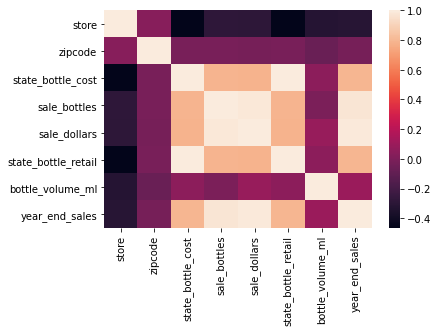

In [48]:
sns.heatmap(new_df.corr())

Creating hold out data (20% of original) for later testing: 

In [62]:
X = new_df.iloc[:, :-1]
y = new_df.iloc[:, -1:]

lr.fit(X, y)
lr.score(X, y)

0.9833614492874465

In [63]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now splitting training data again, into training and validation sets, to create a 60-20-20 model overall: 

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [65]:
lr = LinearRegression()

In [66]:
lr.fit(X_train, y_train)

print("R^2 = ", lr.score(X_val, y_val))
for feature, coef in zip(list(X_train.columns), lr.coef_[0]):
        print(feature, ':', f'{coef:.2f}') 

R^2 =  0.9934597108217418
store : -15.48
zipcode : -0.53
state_bottle_cost : 190186.46
sale_bottles : 4.95
sale_dollars : 4.45
state_bottle_retail : -126777.06
bottle_volume_ml : 9.07


In [67]:
X_train.columns

Index(['store', 'zipcode', 'state_bottle_cost', 'sale_bottles', 'sale_dollars',
       'state_bottle_retail', 'bottle_volume_ml'],
      dtype='object')

Bottle cost and bottle retail are strongly influencing the model and I think I shouldn't have just sum'ed their raw values. Instead, going to calculate the difference and call it "profit" and sum profit over first quarter: 

In [68]:
df["profit"] = df["state_bottle_retail"] - df["state_bottle_cost"]

In [69]:
df

,bottle_volume_ml,category,itemno,pack,sale_bottles,sale_dollars,sale_gallons,sale_liters,state_bottle_cost,state_bottle_retail,store,vendor_no,zipcode,quarter,year_end_sales,profit
0,375,1012100.000,10790,24,1,12.000,0.090,0.370,8.000,12.000,5111,260,52240.000,1,45377.070,4.000
1,375,1012100.000,10805,24,3,36.000,0.290,1.120,8.000,12.000,5111,260,52240.000,1,45377.070,4.000
2,750,1701100.000,10802,12,1,23.390,0.190,0.750,15.590,23.390,5111,260,52240.000,1,45377.070,7.800
3,375,1012100.000,10805,24,2,24.000,0.190,0.750,8.000,12.000,5111,260,52240.000,1,45377.070,4.000
4,375,1012100.000,10790,24,1,12.000,0.090,0.370,8.000,12.000,5111,260,52240.000,1,45377.070,4.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449516,750,1012400.000,15940,12,12,270.000,2.370,9.000,15.000,22.500,5307,240,50131.000,1,274175.220,7.500
449517,750,1051100.000,55086,12,6,49.320,1.180,4.500,5.480,8.220,5307,434,50131.000,1,274175.220,2.740
449518,750,1031200.000,41989,12,3,29.250,0.590,2.250,6.500,9.750,5307,380,50131.000,1,274175.220,3.250
449519,750,1081600.000,64865,12,240,3232.800,47.550,180.000,8.980,13.470,5307,421,50131.000,1,274175.220,4.490


now regrouping original dataframe as above again but including only total profits in first quarter: 

In [70]:
new_df_2 = df.groupby("store").agg({"zipcode": "max", "sale_bottles": "sum", "sale_dollars": "sum", "profit": "sum", "bottle_volume_ml": "mean", "year_end_sales": "max"})


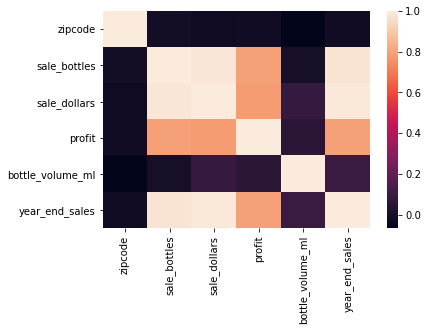

In [72]:
sns.heatmap(new_df_2.corr())

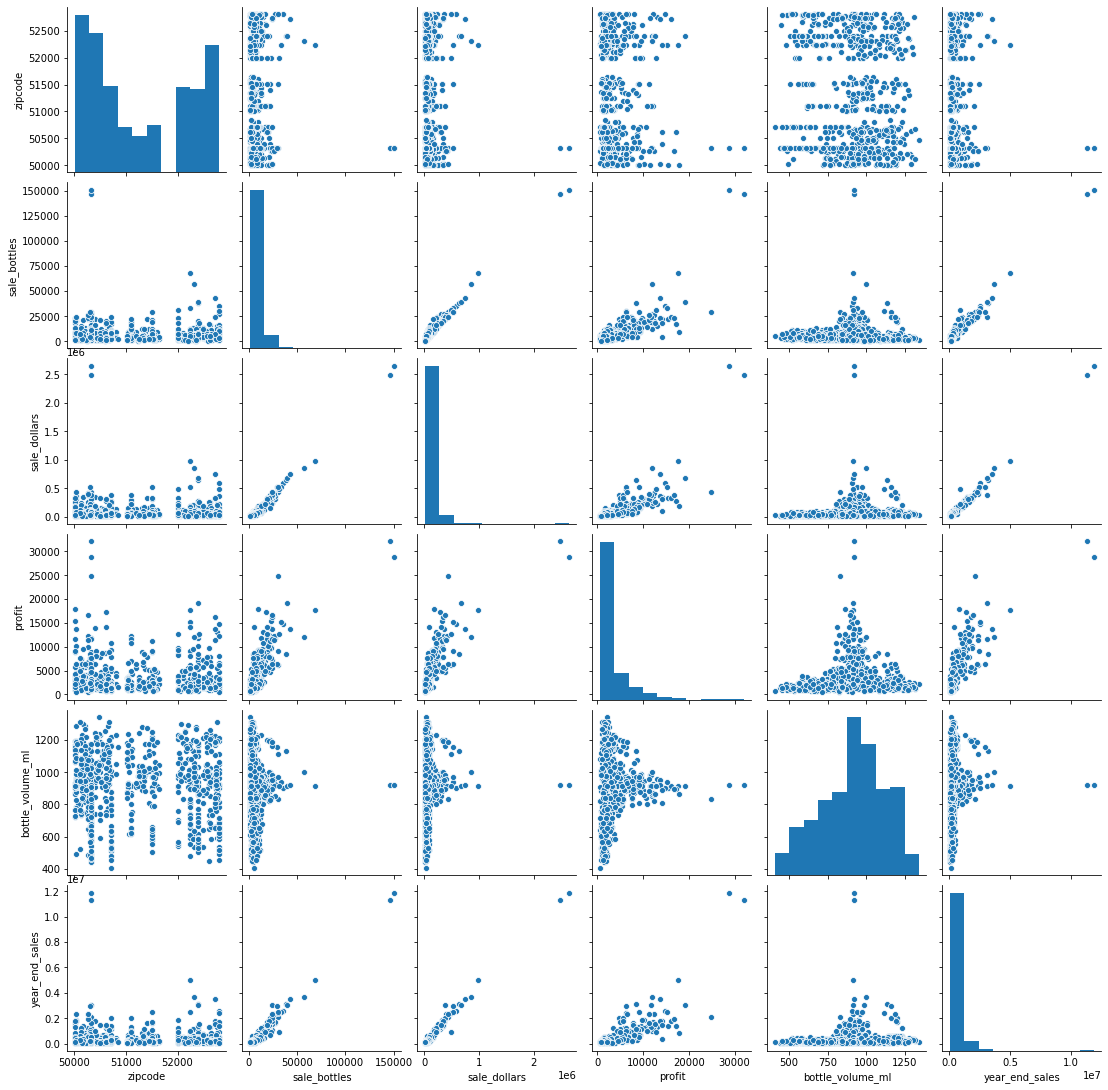

In [73]:
sns.pairplot(new_df_2)

In [84]:
X = new_df_2.iloc[:, :-1]
y = new_df_2.iloc[:, -1:]

In [85]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.25, random_state=42)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(list(X.columns), lr_model.coef_[0]):
        print(feature, ':', f'{coef:.2f}') 
        

In [87]:
split_and_validate(X, y)


Validation R^2 score was: 0.9789915037120371
Feature coefficient results: 

zipcode : -2.76
sale_bottles : 1.93
sale_dollars : 4.32
profit : 11.96
bottle_volume_ml : 60.89


## Conclusion: 
Worked great! Grabbing "profit" category (which was really a sum of "upcharge_per_bottle" = "state_bottle_retail" - "state_bottle_cost"), or the amount they're able to upcharge their bottles over what they're paying for them indicates strongly how their year end sales will be. 

The sale_dollars is also around 4, which is correct because Q1 is a quarter of the year. 

In [2]:
### Other attemptss: 

In [94]:
X2 = X.copy()

X2["bottle_volume_ml^2"] = X2["bottle_volume_ml"] ** 2

split_and_validate(X2, y)


Validation R^2 score was: 0.9793240111406426
Feature coefficient results: 

zipcode : -2.84
sale_bottles : 1.76
sale_dollars : 4.31
profit : 13.63
bottle_volume_ml : -349.41
bottle_volume_ml^2 : 0.23


In [93]:
new_df_2.head()

,zipcode,sale_bottles,sale_dollars,profit,bottle_volume_ml,year_end_sales
store,,,,,,
2106,50613.000,20170,293786.100,5829.460,894.043,1223186.940
2113,50543.000,1490,19676.950,2379.180,958.908,78947.790
2130,50703.000,17756,281669.280,4881.540,975.288,1173271.750
2178,52172.000,4841,66200.410,2950.120,950.440,330402.660
2190,50314.000,29657,428759.040,24817.380,831.114,2124405.100


In [98]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=5, # number of folds 
                scoring='r2') # scoring metric

array([0.98212307, 0.97030474, 0.98710544, 0.97195429, 0.94064868])